In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

snotel_file = '../data/BogusBasinSNOTEL_WY2010_1001-0630.csv'

df = pd.read_csv(snotel_file, \
    names=['Y','M','D','depth','SWE','PRCP_cum','PRCP_day', \
    'T_obs','T_max','T_min','T_avg'],skiprows=1)

# Compute a serial date and append it to the data frame
df['SerDates'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d')

df[0:10]

,Y,M,D,depth,SWE,PRCP_cum,PRCP_day,T_obs,T_max,T_min,T_avg,SerDates
0,2009,10,1,0.0,0.00,0.00,0.00,0.4,2.6,-1.6,0.3,2009-10-01
1,2009,10,2,0.0,0.00,0.00,0.00,-1.9,5.2,-4.7,0.5,2009-10-02
2,2009,10,3,0.0,0.00,0.00,0.00,-0.4,8.3,-2.8,2.4,2009-10-03
3,2009,10,4,127.0,17.78,17.78,17.78,1.1,5.7,-0.4,2.7,2009-10-04
4,2009,10,5,152.4,22.86,40.64,22.86,0.7,3.1,-0.4,1.4,2009-10-05
5,2009,10,6,203.2,20.32,45.72,5.08,-1.2,5.3,-1.3,1.1,2009-10-06
6,2009,10,7,177.8,20.32,45.72,0.00,0.1,7.0,-3.2,0.7,2009-10-07
7,2009,10,8,76.2,20.32,45.72,0.00,3.4,8.1,-1.9,2.8,2009-10-08
8,2009,10,9,50.8,12.70,45.72,0.00,1.5,6.5,-0.7,3.0,2009-10-09
9,2009,10,10,50.8,7.62,45.72,0.00,-1.2,5.0,-1.2,1.5,2009-10-10


In [9]:
P = df['PRCP_day'].values
T = df['T_avg'].values

In [10]:
# Define time step
dt = 1.0

# Define initial conditions
W1_0 = 10.0  # [mm]
W2_0 = 90.0  # [mm]
W3_0 = 125.0 # [mm]

# Store the initial conditions in a numpy array
W0 = np.empty(3)
W0[0] = W1_0
W0[1] = W2_0
W0[2] = W3_0

# Define parameters 
k12   = 0.10  # [day^-1]
k23   = 0.05  # [day^-1]
k3    = 0.02  # [day^-1]
W1max = 30.0  # [mm]
W2max = 175.0 # [mm]
W3max = 250.0 # [mm]
beta  = 2.0   # [-]
rf1   = 0.5   # [%]
rf2   = 0.5   # [%]

# Store the parameters in a numpy array
phi_bm = np.empty(9)
phi_bm[0] = k12
phi_bm[1] = k23
phi_bm[2] = k3
phi_bm[3] = W1max
phi_bm[4] = W2max
phi_bm[5] = W3max
phi_bm[6] = beta
phi_bm[7] = rf1
phi_bm[8] = rf2


In [11]:

Dd = 4.2
Tb = 3.1
SNOF = 1.55
Tscrit = 2.9

phi_sm = np.empty(4)
phi_sm[0] = Dd
phi_sm[1] = Tb
phi_sm[2] = SNOF
phi_sm[3] = Tscrit


In [12]:
def SnowModel(P,T,phi):
    
    Dd     = phi[0]
    Tb     = phi[1]
    SNOF   = phi[2]
    Tscrit = phi[3]

    Nt = T.size

    Mf  = np.zeros(Nt)
    Ps  = np.zeros(Nt)
    Pr  = np.zeros(Nt)
    SWE = np.zeros(Nt)

    for t in np.arange(1,Nt,1):
        if (SWE[t-1] > 0.0) & (T[t] > Tb):
            Mf[t] = np.minimum((Dd*(T[t] - Tb)), SWE[t-1])

        if (P[t]>0.0):
            if (T[t] < Tscrit):
                Ps[t] = SNOF*P[t]
            else:
                Ps[t] = 0.0
                Pr[t] = 0.0

        SWE[t] = SWE[t-1] + Ps[t] - Mf[t]

    return Ps, Pr, SWE, Mf;

In [13]:
def derivs(W,phi,U,dt):

    # Retrieve states, parameters, and forcings from input vectors
    W1 = W[0] 
    W2 = W[1]
    W3 = W[2]
    
    k12   = phi[0]
    k23   = phi[1]
    k3    = phi[2]
    W1max = phi[3]
    W2max = phi[4]
    W3max = phi[5]
    beta  = phi[6]
    rf1   = phi[7]
    rf2   = phi[8]
    
    P  = U[0]
    ET = U[1]
    
    # Create containers to store return values in
    q = np.zeros(5)
    dWdt = np.zeros(3)
    
    # Compute direct runoff using
    qdro = P*(W1/W1max)**beta
    qinf = P - qdro
    
    # Compute between-bucket fluxes
    q12 = np.minimum(k12*W1*dt,W1max - W1)
    q23 = np.minimum(k23*W2*dt,W2max - W2)
    q3  = np.minimum(k3*W3*dt,W3max - W3)
    
    # Compute derivatives
    dW1dt = qinf - (q12 + ET*rf1)
    dW2dt = q12 - (q23 + ET*rf2)
    dW3dt = q23 - q3
    
    # Store computed values in storage containers
    q[0] = qdro
    q[1] = qinf
    q[2] = q12
    q[3] = q23
    q[4] = q3
    
    dWdt[0] = dW1dt
    dWdt[1] = dW2dt
    dWdt[2] = dW3dt
    
    return q, dWdt;

In [14]:
def rk4(Wt,phi,U,dt):
    
    # Get the estimates of the slope required by the RK4 scheme
    flux1, k1 = derivs(Wt,phi,U,dt)
    flux2, k2 = derivs(Wt+k1*dt/2,phi,U,dt)
    flux3, k3 = derivs(Wt+k2*dt/2,phi,U,dt)
    flux4, k4 = derivs(Wt+k3*dt,phi,U,dt)
    
    # Estimate the value of the state at t+dt based on the RK4 slope 
    # estimates computed above
    Wtp1 = Wt + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    
    # Call the derivs function one more time to get the values of the
    # fluxes given the new estimate of the state
    qtp1, dWtp1dt = derivs(Wtp1,phi,U,dt)
    
    return Wtp1, qtp1, dWtp1dt;

In [15]:
def BucketModel(phi,P,T,W0,dt):
        
    # Get length of precipitation vector
    Nt = P.size

    # Create storage containers for simulated states and fluxes
    W    = np.zeros((3,Nt))
    q    = np.zeros((5,Nt))
    dWdt = np.zeros((3,Nt))

    # Create storage container
    U = np.empty(2)

    # Compute the fluxes and derivatives associated with the initial conditions and store them
    U[0] = P[0]
    U[1] = 0.0

    q0, dW0dt = derivs(W0,phi,U,dt)

    # Store the initial values in the simulation storage containers
    W[:,0] = W0
    q[:,0] = q0
    dWdt[:,0] = dW0dt

    # Perform the main simulation loop
    for t in np.arange(1,Nt,1):
        Wt = W[:,t-1]
        U[0] = P[t]
        U[1] = 0.0

        # Call the Runge-Kutta 4 iteration scheme
        Wtp1, qtp1, dWtp1dt = rk4(Wt,phi,U,dt)

        W[:,t] = Wtp1
        q[:,t] = qtp1
        dWdt[:,t] = dWtp1dt
        
    return W, q, dWdt;

# Call the snow model

In [16]:
Ps, Pr, SWE, Mf = SnowModel(P,T,phi_sm)

# Call the Bucket Model

In [18]:
Peff = Pr + Mf

W, q, dWdt = BucketModel(phi_bm,Peff,T,W0,dt)

# Plot results

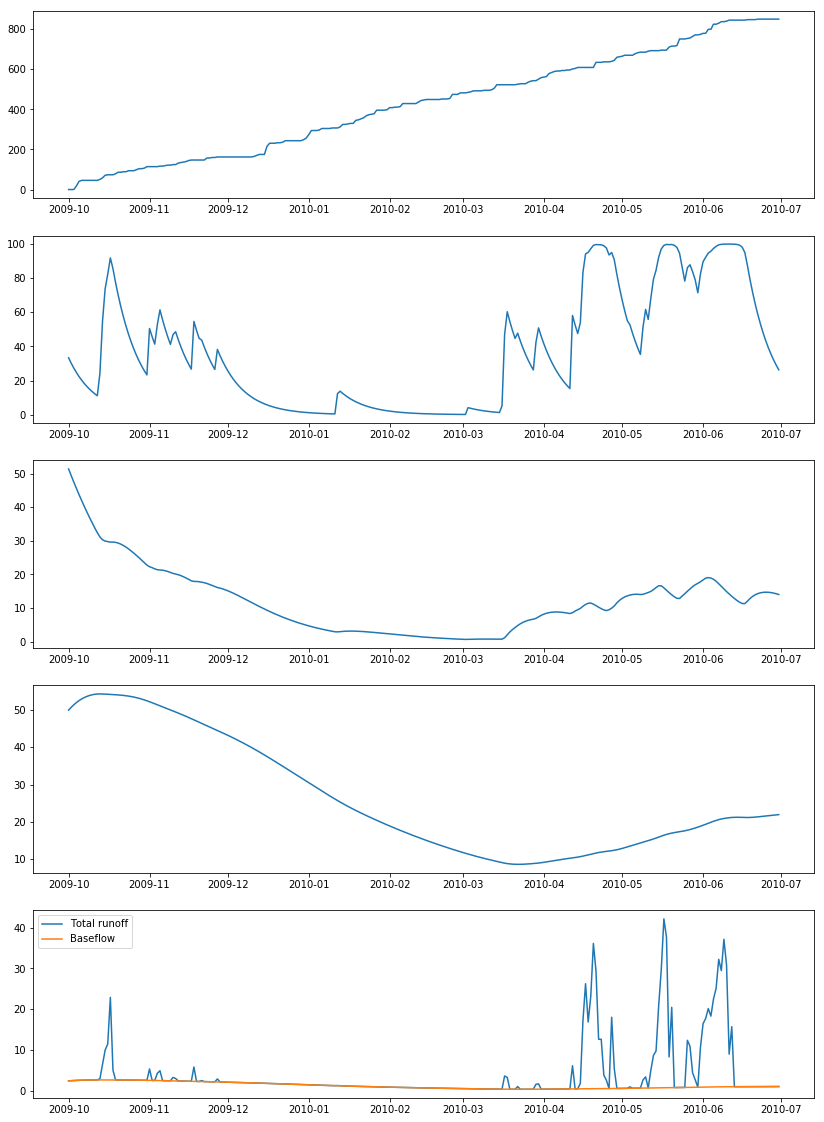

In [20]:
# Plot simulation results
plt.figure(figsize=(14,20))
plt.subplot(511)
plt.plot(df['SerDates'].values,df['PRCP_cum'].values)
plt.subplot(512)
plt.plot(df['SerDates'].values,W[0,:]/W1max*100)
plt.subplot(513)
plt.plot(df['SerDates'].values,W[1,:]/W2max*100)
plt.subplot(514)
plt.plot(df['SerDates'].values,W[2,:]/W3max*100)
plt.subplot(515)
plt.plot(df['SerDates'].values,q[4,:] + q[0,:])
plt.plot(df['SerDates'].values,q[4,:])
plt.legend(('Total runoff','Baseflow'))
plt.show()